# Course Review Topic Modeling

## Exploratory Data Analysis

In [118]:
!git clone https://github.com/RainaVardhan/DS4002-Project-1.git

fatal: destination path 'DS4002-Project-1' already exists and is not an empty directory.


In [119]:
import operator, joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
from sklearn import decomposition
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# settings for our plots later
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

### Load the Data

In [120]:
waterloo=pd.read_csv("/content/DS4002-Project-1/DATA/course_data_clean.csv")
waterloo.head(1)

,course_code,course_title,num_ratings,useful,easy,liked,num_reviews,reviews,course_rating,course_rating_int
0,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,go to office hours and practice,liked course,1.0


### Word Cloud

In [121]:
from wordcloud import WordCloud
import matplotlib.patches as mpatches


In [122]:
waterloo['reviews'] = waterloo['reviews'].fillna('').astype(str)

In [123]:
text = " ".join(waterloo['reviews'])

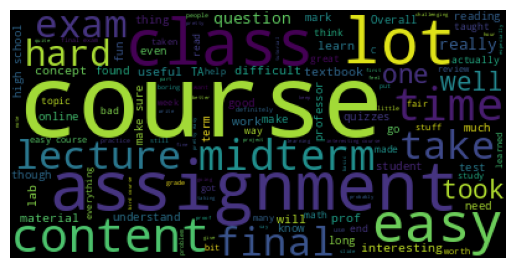

In [124]:
wordcloud2 = WordCloud().generate(text)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

Generate plots to see the frequency of "useful", "easy", and "liked" ratings across all course reviews from the dataset

Text(0.5, 1.0, 'Frequency of Useful Ratings for Course Reviews')

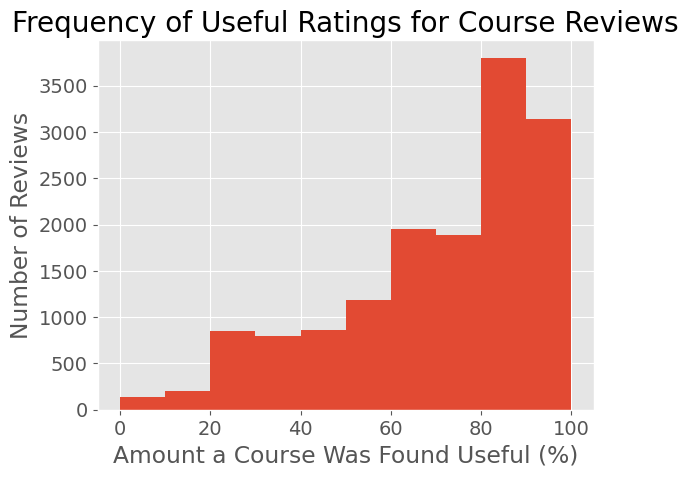

In [125]:
# Clean "useful" column and create plot
waterloo['useful'] = waterloo['useful'].dropna()
waterloo['useful'] = waterloo['useful'].str.rstrip('%').astype('float')
waterloo['useful'].hist()
plt.xlabel('Amount a Course Was Found Useful (%)')
plt.ylabel('Number of Reviews')
plt.title('Frequency of Useful Ratings for Course Reviews')

Text(0.5, 1.0, 'Frequency of Easy Ratings for Course Reviews')

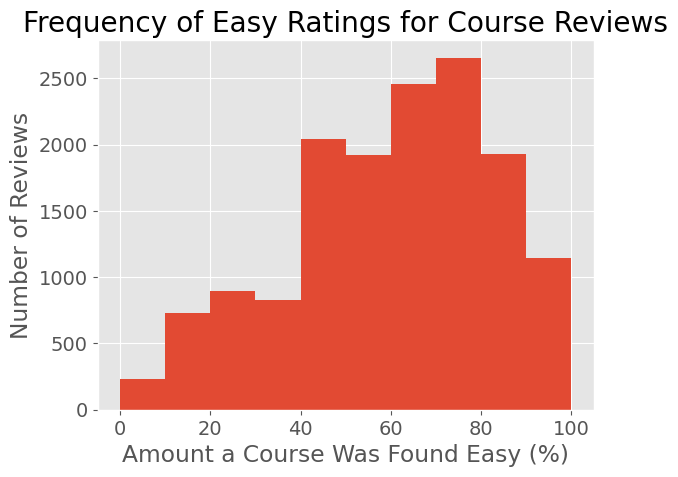

In [126]:
# Clean "easy" column and create plot
waterloo['easy'] = waterloo['easy'].dropna()
waterloo['easy'] = waterloo['easy'].str.rstrip('%').astype('float')
waterloo['easy'].hist()
plt.xlabel('Amount a Course Was Found Easy (%)')
plt.ylabel('Number of Reviews')
plt.title('Frequency of Easy Ratings for Course Reviews')

Text(0.5, 1.0, 'Frequency of Liked Ratings for Course Reviews')

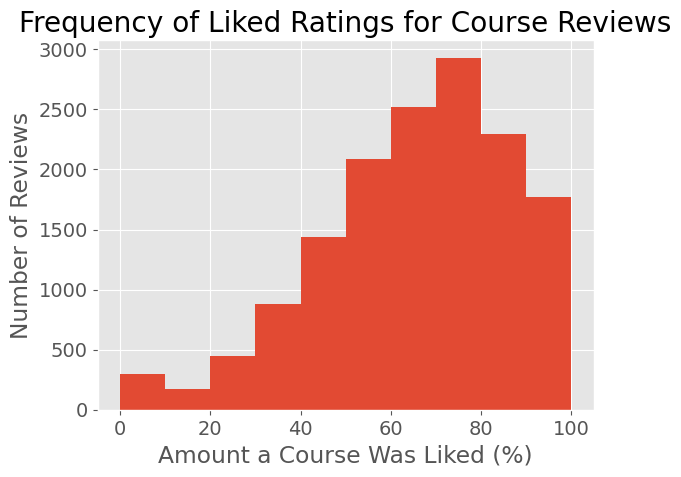

In [127]:
# Clean "liked" column and create plot
waterloo['liked'] = waterloo['liked'].dropna()
waterloo['liked'] = waterloo['liked'].str.rstrip('%').astype('float')
waterloo['liked'].hist()
plt.xlabel('Amount a Course Was Liked (%)')
plt.ylabel('Number of Reviews')
plt.title('Frequency of Liked Ratings for Course Reviews')

Interesting... there appears to be more of a negative skew in the frequency of "useful" ratings for course reviews and more approximately normal distributions for the frequencies of "easy" and "liked" ratings.

## General Topic Modeling

### Load Custom Stop Words

In [128]:
custom_stop_words = []
with open( "/content/DS4002-Project-1/DATA/stopwords copy.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip())
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 363 entries


# For Positive ECON 101 reviews


In [129]:
ECON_rocks = waterloo[(waterloo['course_code'] == 'ECON 101') & (waterloo['course_rating']=='liked course')]

In [130]:
Econ_pos_reviews = ECON_rocks['reviews']
Econ_pos_reviews = Econ_pos_reviews.dropna()
Econ_pos_reviews = Econ_pos_reviews.to_list()
Econ_pos_reviews[0:3]

['Very simple',
 'Took online, almost all multiple choice, a lot of questions are common sense',
 "PROS: (1) Readings itself were simple to understand. (2) Nicely arranged content on Learn and Mobius (I took it online). (3) Decent grade, task, and submission period distribution. CONS: (1) Too many readings for a first-time learner of econ. (2) One collective zoom office hour (1 hour long) at the beginning of the week felt very unfair (3) Found a need for more OHs each week and a MS teams GC. (4) Felt isolated from the rest of the class. (5) lack of one-to-one instructional support (unless you email every question). (6) Had to refer to external resources for quicker understanding because readings were too time consuming. (7) Weren't taught at all on how to approach an article/case study. TIPS: (1) Finish all readings in the first two days of the week, (2) repeat quizzes till you get them correct (you get 4 chances per graded quiz every week, please use these well). (3) Don’t just read t

In [131]:
# use a custom stopwords list, set the minimum term-document frequency to 2
vectorizer = CountVectorizer(stop_words = custom_stop_words, min_df=2)
A = vectorizer.fit_transform(Econ_pos_reviews)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Created 98 X 151 document-term matrix


In [132]:
econ_terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(econ_terms))

Vocabulary has 151 distinct terms


In [133]:
snippets = [Econ_pos_reviews[:100] for Econ_pos_reviews in Econ_pos_reviews]
snippets[0:3]

['Very simple',
 'Took online, almost all multiple choice, a lot of questions are common sense',
 'PROS: (1) Readings itself were simple to understand. (2) Nicely arranged content on Learn and Mobius']

In [134]:
joblib.dump((A,econ_terms,snippets), "/content/DS4002-Project-1/OUTPUT/Econ-pos-reviews-raw.pkl")

['/content/DS4002-Project-1/OUTPUT/Econ-pos-reviews-raw.pkl']

In [135]:
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 2)
A = vectorizer.fit_transform(Econ_pos_reviews)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

Created 98 X 151 TF-IDF-normalized document-term matrix


In [136]:
econ_terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(econ_terms))

Vocabulary has 151 distinct terms


In [137]:
def rank_terms(A, term):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(econ_terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

### Most common words

In [138]:
ranking = rank_terms(A, econ_terms)
for i, pair in enumerate(ranking[0:20]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1] ))

01. easy (13.60)
02. textbook (5.62)
03. concepts (3.80)
04. study (3.77)
05. good (3.75)
06. questions (3.70)
07. lectures (3.56)
08. choice (3.49)
09. multiple (3.49)
10. read (3.48)
11. economics (3.31)
12. interesting (3.29)
13. practice (3.01)
14. guide (2.99)
15. hard (2.90)
16. useful (2.82)
17. content (2.73)
18. simple (2.72)
19. boring (2.54)
20. high (2.49)


In [139]:
joblib.dump((A,econ_terms,snippets), "/content/DS4002-Project-1/OUTPUT/Econ-pos-reviews-tfidf.pkl")

['/content/DS4002-Project-1/OUTPUT/Econ-pos-reviews-tfidf.pkl']

In [140]:
(A, econ_terms, snippets) = joblib.load("/content/DS4002-Project-1/OUTPUT/Econ-pos-reviews-tfidf.pkl")
print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 98 X 151 document-term matrix


In [141]:
k=4
# create the model, specifiying the initialization strategy and the number of topics to produce
model = decomposition.NMF(init="nndsvd", n_components=k)
# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

In [142]:
# round to 2 decimal places for display purposes
W[0,:].round(2)

array([0.  , 0.  , 0.  , 0.17])

In [143]:
term_index = econ_terms.index('exam')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([0.  , 0.02, 0.03, 0.07])

In [144]:
def get_descriptor(econ_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index,:])[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(econ_terms[term_index])
    return top_terms

In [145]:
descriptors = []
for topic_index in range(k):
    descriptors.append(get_descriptor( econ_terms, H, topic_index, 7))
    str_descriptor = ", ".join(descriptors[topic_index])
    print("Topic %02d: %s" % (topic_index+1, str_descriptor))

Topic 01: easy, boring, light, work, fun, hard, grade
Topic 02: textbook, questions, read, study, guide, material, lectures
Topic 03: choice, multiple, online, took, exams, final, before
Topic 04: economics, concepts, high, good, school, simple, useful


Topic 01: Course difficulty and enjoyability

Topic 02: Learning tools

Topic 03: Exams

Topic 04: Course content

In [146]:
econ_topic_set = ['Topic 01: Course difficulty and enjoyability', 'Topic 02: Learning tools', 'Topic 03: Exams', 'Topic 04: Course content']

Note that the topic numbers are arbitrary. Topic 1 is not necessarily more prevalent than topic 2, but these should be like the top 4 topics

In [147]:
def plot_top_term_weights(econ_terms, H, topic_index, top):
    # get the top terms and their weights
    top_indices = np.argsort(H[topic_index,:])[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append(econ_terms[term_index])
        top_weights.append(H[topic_index,term_index])
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

Topic 01: Course difficulty and enjoyability : 


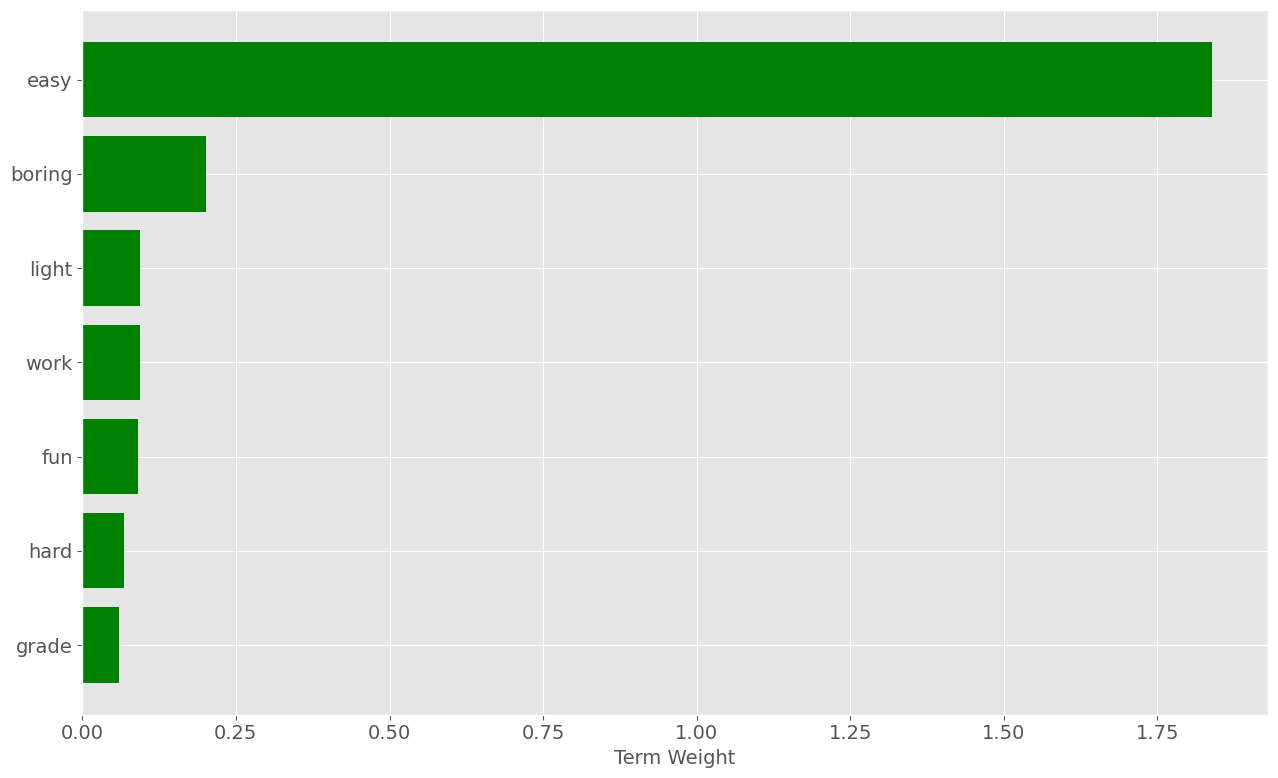

Topic 02: Learning tools : 


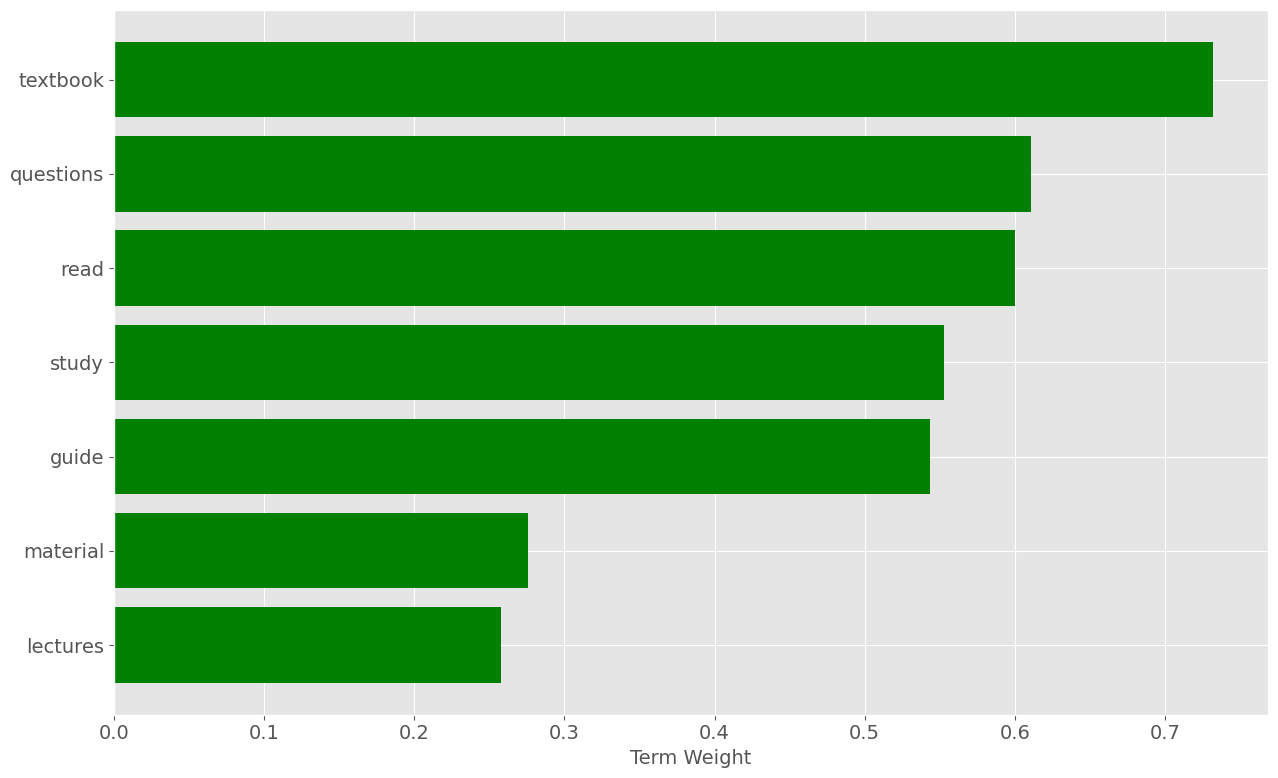

Topic 03: Exams : 


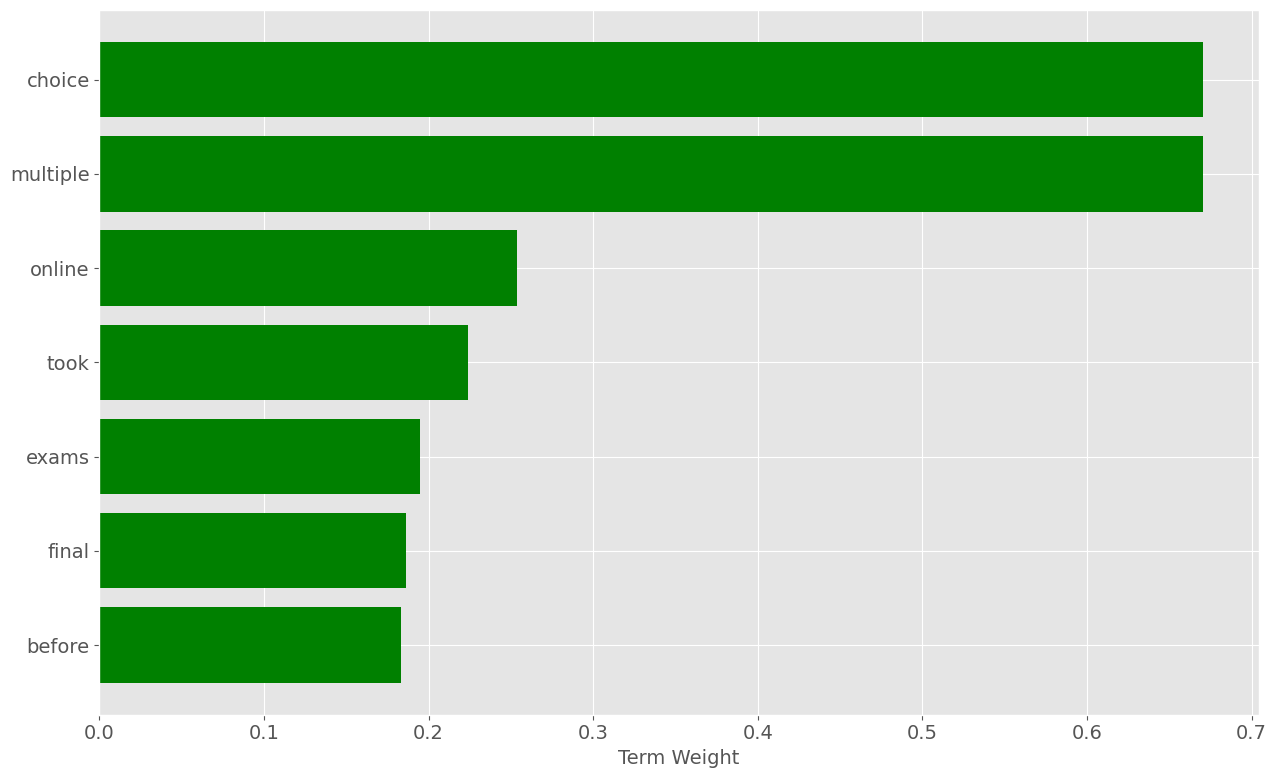

Topic 04: Course content : 


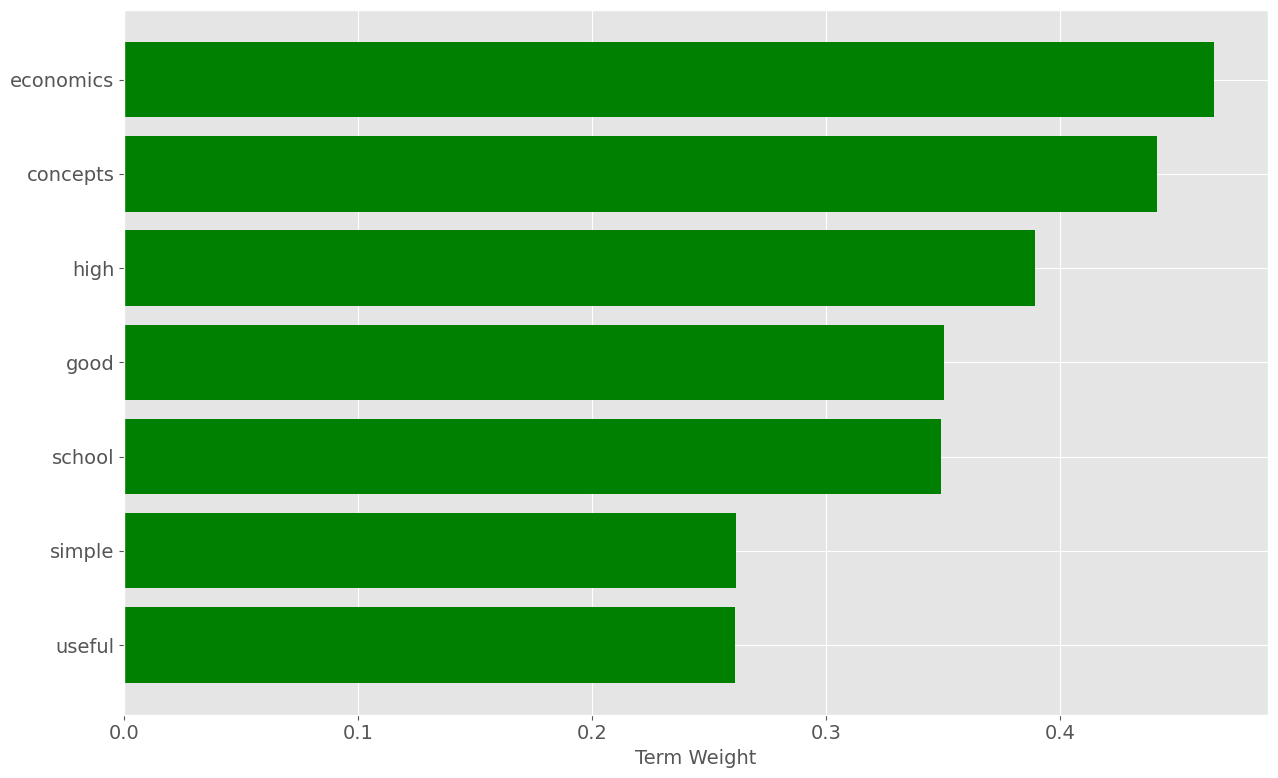

In [148]:
for i in range(len(econ_topic_set)):
  print(econ_topic_set[i], ": ")
  plot_top_term_weights(econ_terms, H, i, 7)


In [149]:
def get_top_snippets(all_snippets, W, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append(all_snippets[doc_index])
    return top_snippets

In [150]:
topic_snippets = get_top_snippets(snippets, W, 2, 10)
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ((i+1), snippet ))

01. Easy bird course. Multiple choice ftw.
02. Took online, almost all multiple choice, a lot of questions are common sense
03. Super easy if you do it online, there was no midterm and the final was going to be all multiple choi
04. Took it as a CSE, highest graded CSE course I have on record. Multiple choice midterm and final exam
05. All multiple choice, all about memory and understanding. One of the easiest courses in first year
06. Easy course if you NEVER took econ before.. probably extremely boring if you have taken econ before.
07. I only went to 3 lectures the entire semester. Works well if you only get multiple choice exams. It'
08. Very interesting course because my prof (Packalen) was into the application of learned concepts inst
09. Read the text book, do those multiple choice questions from the study guide then you will be all set
10. Easy bird course for any student looking to fill an elective. Course goes over a lot of concepts in 


# For Positive CS 101 reviews

In [151]:
CS_rocks = waterloo[(waterloo['course_code'] == 'CS 115') & (waterloo['course_rating']=='liked course')]
CS_pos_reviews = CS_rocks['reviews']
CS_pos_reviews = CS_pos_reviews.dropna()
CS_pos_reviews = CS_pos_reviews.to_list()
CS_pos_reviews[0:5]


['go to office hours and practice',
 "Took this in 2018 with no programming experience ever. Started out pretty slow, but I didn't really pay attention and was severely behind. Went to a lot of office hours, but nonetheless caught up and did decently well. After taking more cs courses, racket really is a weird language.",
 "I loved everything about cs 115. Great instructors, fair assignments ( can get tricky but there's a huge amount of office hours to attend ), good engagement and interesting topics! It's seriously well structured and I would recommend it to anyone even with no background in coding.",
 'I recommend finding a course with a language that is actually useful. Racket is dumb and never used anywhere. The majority of the course was quite easy, except a couple of concept checks that were RIDICULOUSLY HARD. i wish i had realized sooner that you get 10% of concept checks dropped from your grade. if you understand everything and are getting most things easily but you get stumped

In [152]:
# use a custom stopwords list, set the minimum term-document frequency to 2
vectorizer = CountVectorizer(stop_words = custom_stop_words, min_df=2)
A = vectorizer.fit_transform(CS_pos_reviews)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(terms))

CS_snippets = [CS_pos_reviews[:100] for CS_pos_reviews in CS_pos_reviews]
CS_snippets[0:5]

Created 65 X 152 document-term matrix
Vocabulary has 152 distinct terms


['go to office hours and practice',
 "Took this in 2018 with no programming experience ever. Started out pretty slow, but I didn't really ",
 "I loved everything about cs 115. Great instructors, fair assignments ( can get tricky but there's a ",
 'I recommend finding a course with a language that is actually useful. Racket is dumb and never used ',
 'I really enjoyed this course online, being co-taught by 4 professors. There were lots of office hour']

In [153]:
joblib.dump((A,terms,CS_snippets), "/content/DS4002-Project-1/OUTPUT/CS-pos-reviews-raw.pkl")

['/content/DS4002-Project-1/OUTPUT/CS-pos-reviews-raw.pkl']

In [154]:
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 2)
A = vectorizer.fit_transform(CS_pos_reviews)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

terms =  list(vectorizer.get_feature_names_out())
print("Vocabulary has %d distinct terms" % len(terms))

Created 65 X 152 TF-IDF-normalized document-term matrix
Vocabulary has 152 distinct terms


In [155]:
def rank_terms(A, term):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [156]:
ranking = rank_terms(A, terms)
for i, pair in enumerate(ranking[0:20]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1] ))

01. easy (6.75)
02. good (4.44)
03. assignments (4.29)
04. programming (4.22)
05. racket (4.12)
06. fun (3.32)
07. time (3.17)
08. experience (2.71)
09. hours (2.36)
10. help (2.25)
11. concepts (2.24)
12. scheme (2.21)
13. interesting (2.15)
14. difficult (2.13)
15. office (2.04)
16. language (1.87)
17. questions (1.84)
18. science (1.82)
19. overall (1.81)
20. online (1.74)


In [157]:
joblib.dump((A,terms,CS_snippets), "/content/DS4002-Project-1/OUTPUT/CS-pos-reviews-tfidf.pkl")

['/content/DS4002-Project-1/OUTPUT/CS-pos-reviews-tfidf.pkl']

In [158]:
(A, terms, CS_snippets) = joblib.load("/content/DS4002-Project-1/OUTPUT/CS-pos-reviews-tfidf.pkl")
print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 65 X 152 document-term matrix


In [159]:
k=4
# create the model, specifiying the initialization strategy and the number of topics to produce
model = decomposition.NMF(init="nndsvd", n_components=k)
# apply the model and extract the two factor matrices
W_CS = model.fit_transform( A )
H_CS = model.components_

# round to 2 decimal places for display purposes
W_CS[0,:].round(2)



array([0.  , 0.  , 0.03, 0.25])

In [160]:
H_CS[:,term_index].round(2)

array([0.08, 0.  , 0.  , 0.08])

In [161]:
def get_descriptor(terms, H_CS, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H_CS[topic_index,:])[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
    return top_terms

In [162]:
descriptors = []
for topic_index in range(k):
    descriptors.append(get_descriptor( terms, H_CS, topic_index, 10))
    str_descriptor = ", ".join(descriptors[topic_index])
    print("Topic %02d: %s" % (topic_index+1, str_descriptor))

Topic 01: easy, assignments, interesting, relatively, material, notes, labs, keep, little, overall
Topic 02: programming, racket, good, experience, concepts, language, science, computer, introduction, useful
Topic 03: fun, codes, writing, enjoyed, scheme, overall, languages, language, lot, hard
Topic 04: time, assignments, help, online, hours, office, content, weekly, questions, tas


Topic 01: Difficulty

Topic 02: Programming

Topic 03: Enjoyability

Topic 04: Time Management & Help

In [163]:
cs_topic_set = ['Topic 01: Difficulty', 'Topic 02: Programming', 'Topic 03: Enjoyability', 'Topic 04: Time Management & Help']

In [164]:
def plot_top_term_weights(terms, H_CS, topic_index, top):
    # get the top terms and their weights
    top_indices = np.argsort(H_CS[topic_index,:])[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
        top_weights.append(H_CS[topic_index,term_index])
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

Topic 01: Difficulty : 


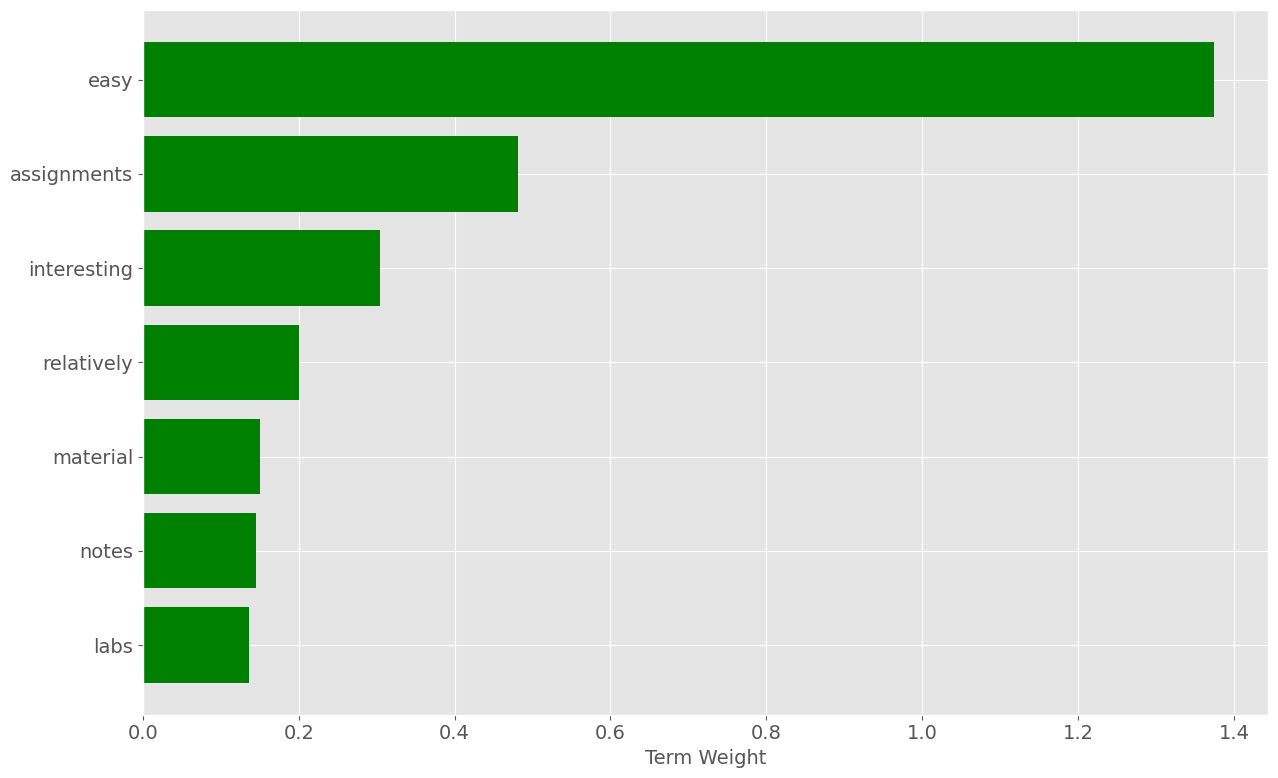

Topic 02: Programming : 


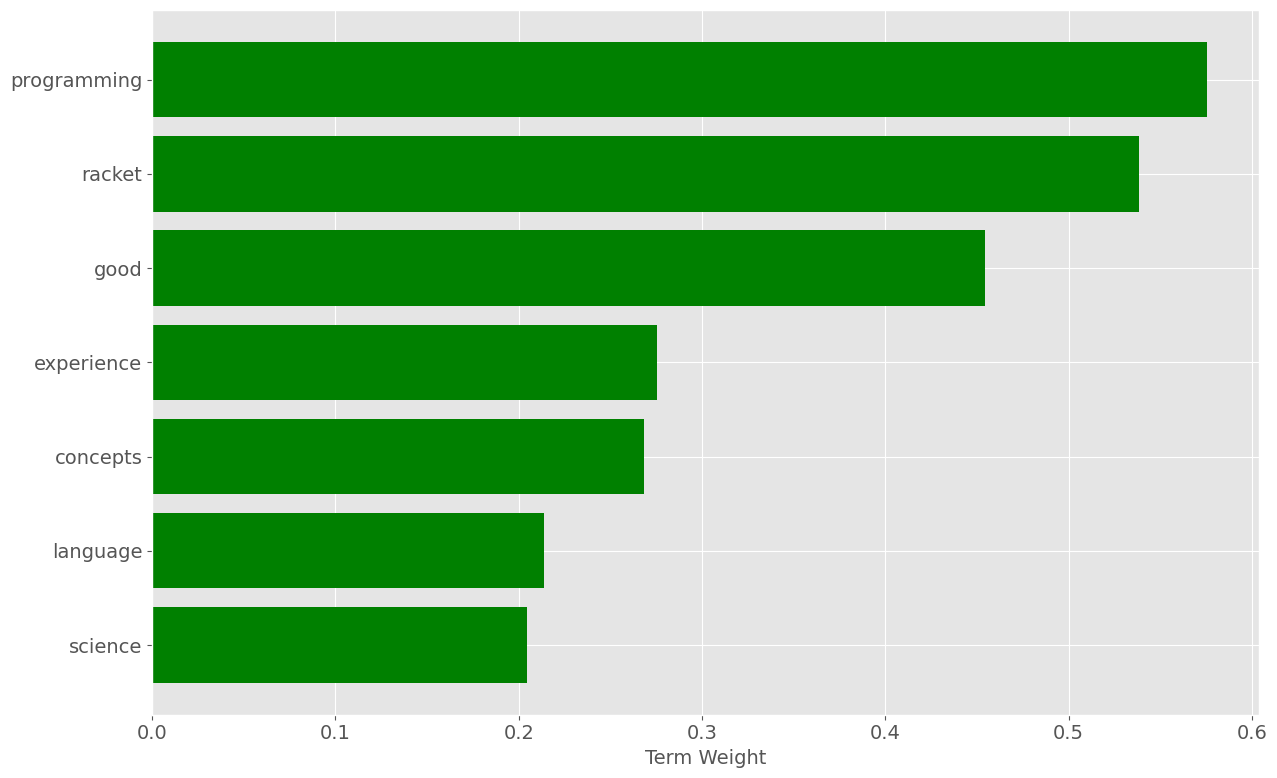

Topic 03: Enjoyability : 


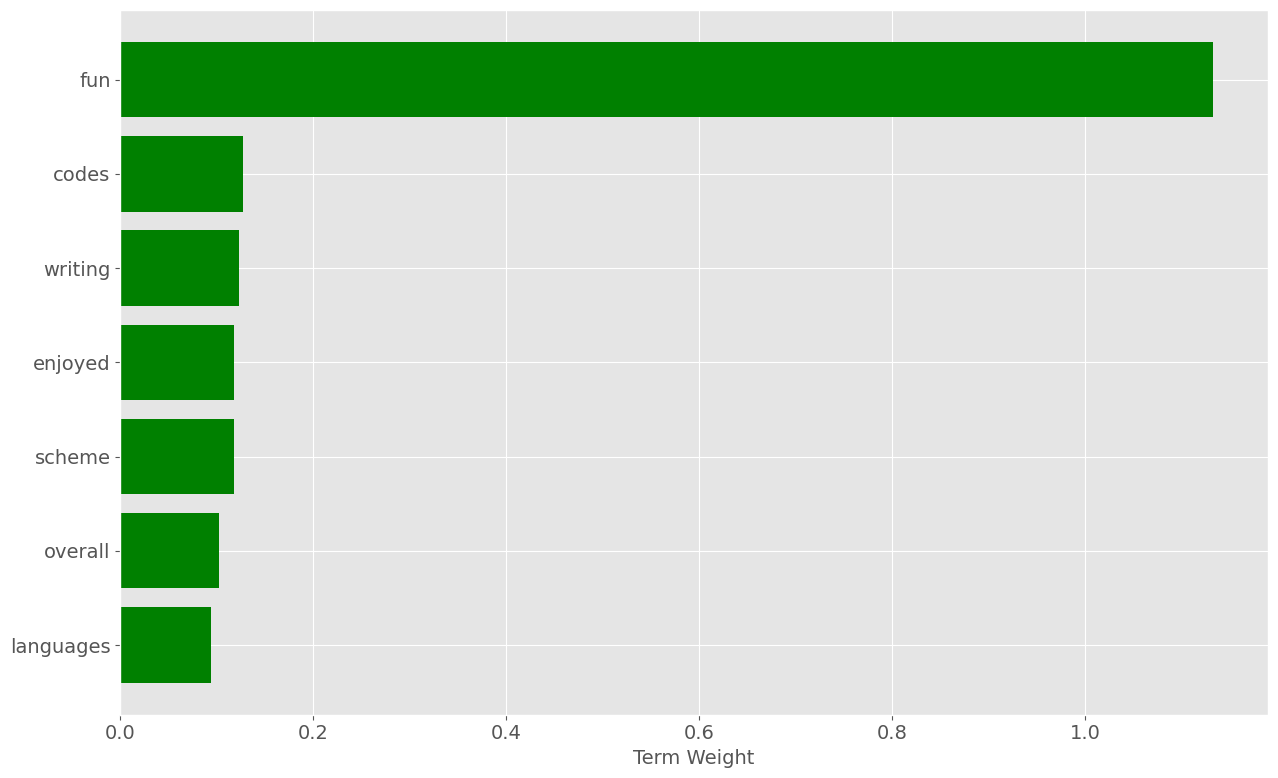

Topic 04: Time Management & Help : 


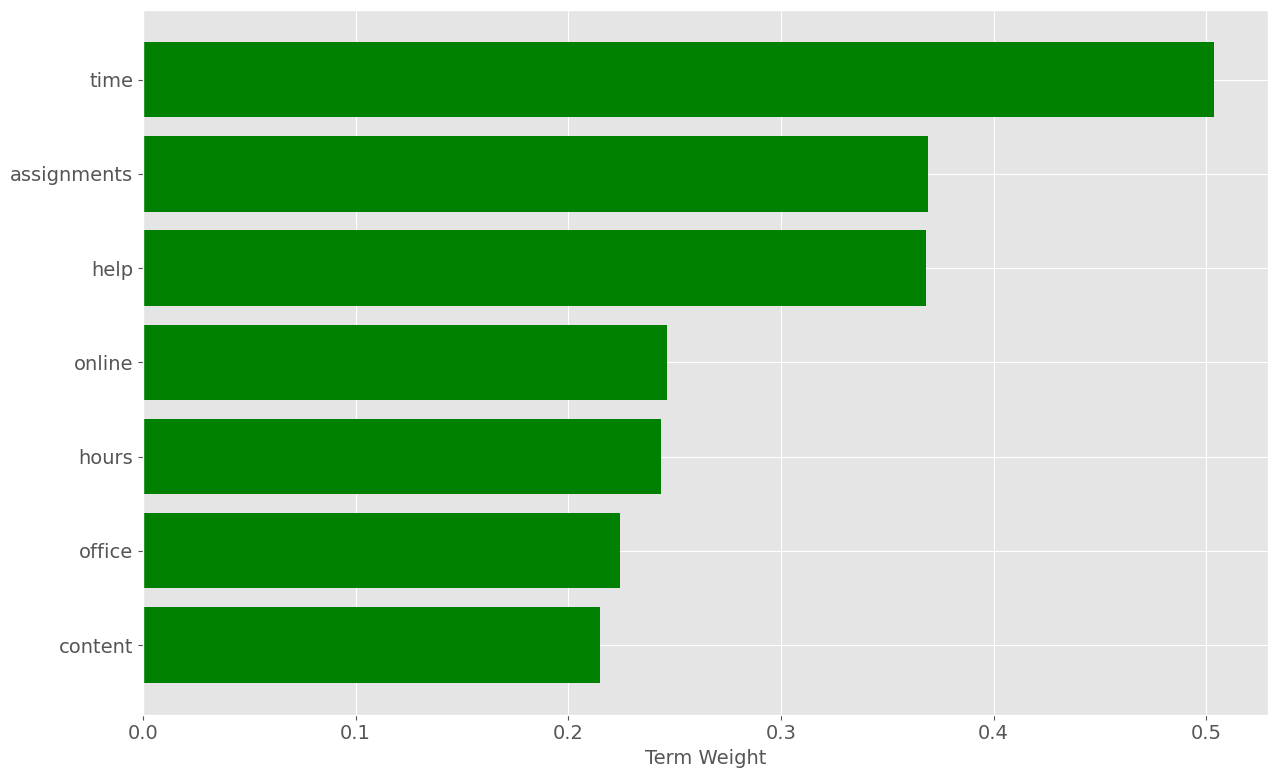

In [165]:
for i in range(len(cs_topic_set)):
  print(cs_topic_set[i], ": ")
  plot_top_term_weights(terms, H_CS, i, 7)

In [166]:
topic_snippets = get_top_snippets(CS_pos_reviews, W_CS, 1, 10)
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ((i+1), snippet ))

01. The programming language (Scheme/Dr.Racket) wasn't a very good program to use but the concepts behind it are the same I guess ...
02. Not a bird course, although if you have background in programming it would not be difficult at all. Racket is somewhat useless but I learned some concepts that will be useful for other programming languages
03. If you feel like you have sufficient Computer Science experience, go to CS 135 because it does challenge you more. This is a good introductory course to learn programming. Also, Racket needs some getting used to.
04. I took this course online due to the COVID-19 pandemic, so my review is based on a remote, online learning experience. Overall, as someone who is not a CS student and who doesn't have a lot of background experience and knowledge in programming, it's a great introductory course to the language of Racket and the overall concepts that will be useful in later computer science courses. The Racket language itself is not a very "useful" 